In [81]:
%matplotlib inline
from tqdm import tqdm

import numpy as np

import torch
from torch.distributions import Categorical, constraints
from torch.autograd import Variable

from helpers import make_transition_matrix

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk')

zeros = torch.zeros
ones = torch.ones
randn = torch.randn
softplus = torch.nn.Softplus()

In [82]:
na = 2
ns = 6

# load planet cofigurations and starting positions
vect = np.load('confsExp1.npy')
ol_exp1 = torch.from_numpy(vect)
ol_exp2 = torch.from_numpy(np.vstack([vect[50:], vect[:50]]))

vect = np.load('startsExp1.npy')
starts_exp1 = torch.from_numpy(vect)
starts_exp2 = torch.from_numpy(np.hstack([vect[50:], vect[:50]]))

# state transition matrix c, a, s -> s'
p = [.9, .5]
stm_low = make_transition_matrix(p[0], ns, na)
stm_high = make_transition_matrix(p[1], ns, na)
stm = torch.stack([stm_low, stm_high])

# planning depths
pd_exp1 = torch.tensor([2, 3]).repeat(50, 1)\
    .transpose(dim0=1, dim1=0).contiguous().view(-1)
pd_exp2 = torch.stack([pd_exp1[50:], pd_exp1[:50]]).view(-1)

action_costs = torch.tensor([-.2, -.5]).repeat(2, 1)  # action costs

val_exp1 = ol_exp1.argmax(dim=-1).float() - 2.
val_exp2 = ol_exp2.argmax(dim=-1).float() - 2.

log_pd = 0  # uniform prior probability on depth

In [83]:
# getting the optimal planning depth with backward inference

N = 100  # number of mini-blocks
optimal_depth = torch.zeros(N, 2, dtype=torch.long)
number_of_jumps = zeros(N, 2)
for i in range(N):

    start = starts_exp1[i]

    max_depth = pd_exp1[i]
    
    Q = torch.zeros(2, na, ns, max_depth)
    R = torch.einsum('ijkl,l->ijk', (stm, val_exp1[i])) + action_costs[..., None]

    Q[..., 0] = R
    for depth in range(1, max_depth):
        # compute response probability
        p = 1/(1+torch.exp((Q[:, 0, :, depth-1] - Q[:, 1, :, depth-1])/1e-10))

        # set state value
        V = p*Q[:, 1, :, depth-1] + (1-p)*Q[:, 0, :, depth-1]

        Q[..., depth] = R + torch.einsum('ijkl,il->ijk', (stm, V))

    qa = torch.ones(2, ns, na)/na
    qd = torch.ones(2, ns, max_depth)/max_depth.item()

    for _ in range(10):
        log_qa = torch.einsum('ikl,ijkl->ikj', (qd, Q))
        log_qd = torch.einsum('ijk,ikjl->ijl', (qa, Q)) + log_pd
    
        qa = torch.exp(log_qa)
        qa /= qa.sum(dim=-1, keepdim=True)
        qd = torch.exp(log_qd)
        qd /= qd.sum(dim=-1, keepdim=True)
    
    optimal_depth[i] = qd[:, start].argmax(dim=-1)+1
    number_of_jumps[i] = qa[:, start].argmax(dim=-1)


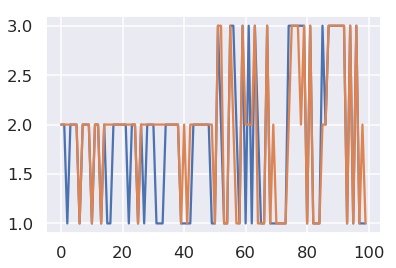

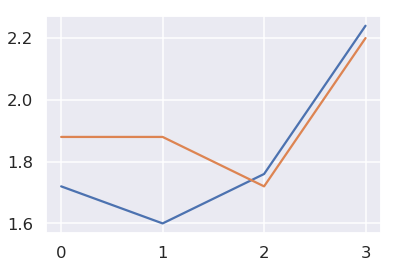

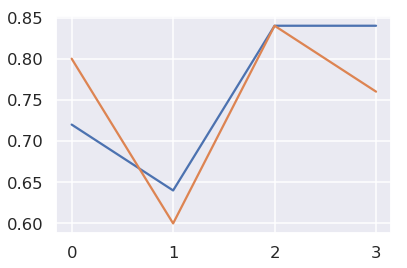

In [84]:
plt.figure();
plt.plot(optimal_depth.numpy());

plt.figure();
plt.plot(optimal_depth.reshape(4, -1, 2).numpy().mean(axis=1));

plt.figure();
plt.plot(number_of_jumps.reshape(4, -1, 2).numpy().mean(axis=1));

In [85]:
def inf_to_nul(x):
    x[-x == float("Inf")] = 0.
    return x

def get_fe(x, pref):
    return (-x*pref + x*inf_to_nul(torch.log(x))).sum(dim=-1)

def get_util(x, pref):
    return (-x*pref).sum(dim=-1)

policies = [[0], [1], 
            [0, 0], [0, 1], [1, 0], [1, 1],
            [0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]]

In [86]:
# get the optimal planning depth by maximasing only the expected utility over policies

optimal_depth = zeros(N, 2)
number_of_jumps = zeros(N, 2)
for i in range(N):
    preferences = val_exp1[i][:, None] + action_costs[0][None, :]
    start = starts_exp1[i]

    max_depth = pd_exp1[i]
    stm[:,:,start]
    q_s_pi = [stm[:,0,start], stm[:,1,start]]
    FE = [get_util(stm[:,0,start], preferences[:,0]), get_util(stm[:,1,start], preferences[:,1])]
    for d in range(1,max_depth):
        new_q_s_pi = []
        new_FE = []
        for prev_q_s_pi, prev_FE in zip(q_s_pi[-2**(d):], FE[-2**d:]):
            for u in range(2):
                tmp = (prev_q_s_pi[:,:,None]*stm[:,u]).sum(dim=-2)
                new_q_s_pi.append(tmp)
                new_FE.append(prev_FE + get_util(tmp, preferences[:,u]))
            
        q_s_pi += new_q_s_pi
        FE += new_FE
    
    FE = torch.stack(FE)
    best_pi = FE.argmin(dim=0)
    optimal_depth[i, 0] = len(policies[best_pi[0]])
    optimal_depth[i, 1] = len(policies[best_pi[1]])
    
    number_of_jumps[i, 0] = policies[best_pi[0]][0]
    number_of_jumps[i, 1] = policies[best_pi[1]][0]

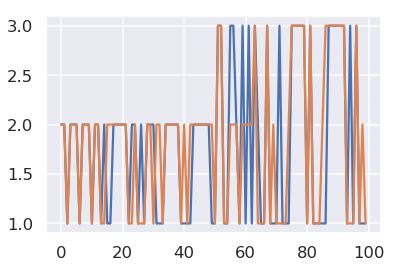

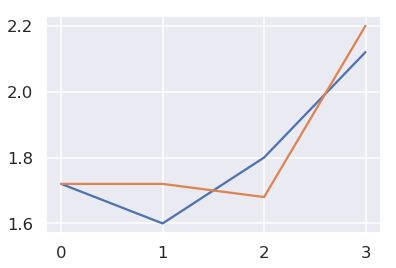

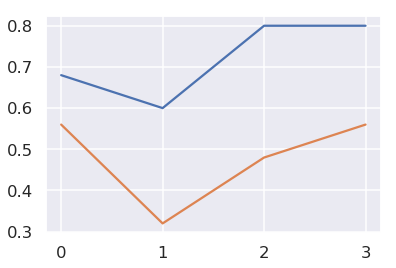

In [87]:
plt.figure();
plt.plot(optimal_depth.numpy());

plt.figure();
plt.plot(optimal_depth.reshape(4, -1, 2).numpy().mean(axis=1));

plt.figure();
plt.plot(number_of_jumps.reshape(4, -1, 2).numpy().mean(axis=1));

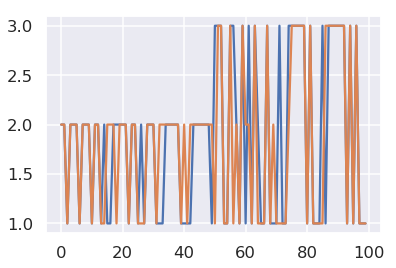

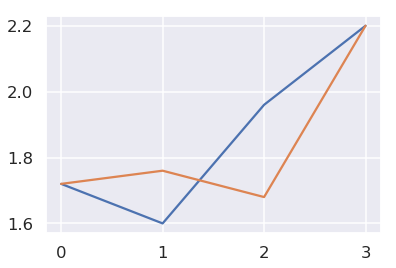

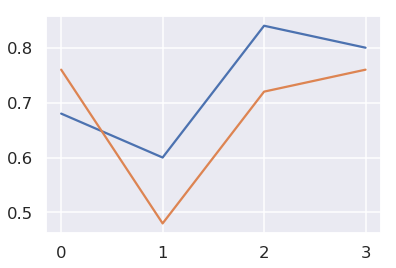

In [88]:
# get the optimal planning depth by minimising expcted free energy over policies

optimal_depth = zeros(N, 2)
number_of_jumps = zeros(N, 2)
for i in range(N):
    preferences = 10*(val_exp1[i][:, None] + action_costs[0][None, :])
    start = starts_exp1[i]

    max_depth = pd_exp1[i]
    stm[:,:,start]
    q_s_pi = [stm[:,0,start], stm[:,1,start]]
    FE = [get_fe(stm[:,0,start], preferences[:,0]), get_fe(stm[:,1,start], preferences[:,1])]
    for d in range(1,max_depth):
        new_q_s_pi = []
        new_FE = []
        for prev_q_s_pi, prev_FE in zip(q_s_pi[-2**(d):], FE[-2**d:]):
            for u in range(2):
                tmp = (prev_q_s_pi[:,:,None]*stm[:,u]).sum(dim=-2)
                new_q_s_pi.append(tmp)
                new_FE.append(prev_FE + get_fe(tmp, preferences[:,u]))
            
        q_s_pi += new_q_s_pi
        FE += new_FE
    
    best_pi = torch.stack(FE).argmin(dim=0)
    optimal_depth[i, 0] = len(policies[best_pi[0]])
    optimal_depth[i, 1] = len(policies[best_pi[1]])
    
    number_of_jumps[i, 0] = policies[best_pi[0]][0]
    number_of_jumps[i, 1] = policies[best_pi[1]][0]
    
plt.figure()
plt.plot(optimal_depth.numpy());

plt.figure()
plt.plot(optimal_depth.reshape(4, -1, 2).numpy().mean(axis=1));

plt.figure()
plt.plot(number_of_jumps.reshape(4, -1, 2).numpy().mean(axis=1));